# Clustering to Ascertain Millitary Dependencies

# Import Libraries and Load Data
Import necessary libraries such as pandas, numpy, matplotlib, and scikit-learn. Load the SIPRI nested JSON data and preprocess it into a flat dataframe structure suitable for analysis.

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the SIPRI nested JSON data
with open('../data/sipri_milex_data_nested.json') as f:
    data = json.load(f)

# Function to flatten the nested structure
def flatten_country_data(country_data):
    rows = []
    country_name = country_data['name']
    country_iso = country_data['ISO']
    
    for time_point in country_data['time_series']:
        if not time_point:  # Skip empty time points
            continue
            
        row = {
            'country_name': country_name,
            'ISO': country_iso,
            'year': time_point.get('year'),
            'military_expenditure': time_point.get('military_expenditure'),
            'military_expenditure_gdp': time_point.get('military_expenditure_gdp')
        }
        
        # Extract arms trading data if available
        if 'arms_trading' in time_point:
            arms_data = time_point['arms_trading']
            
            # Process imports
            if 'imports' in arms_data:
                for imp in arms_data['imports']:
                    row[f'imports_{imp["partner"]}'] = imp['value']
            
            # Process exports
            if 'exports' in arms_data:
                for exp in arms_data['exports']:
                    row[f'exports_{exp["partner"]}'] = exp['value']
        
        rows.append(row)
    
    return rows

# Process all countries
all_rows = []
for country in data['countries']:
    country_rows = flatten_country_data(country)
    all_rows.extend(country_rows)

# Create dataframe
df = pd.DataFrame(all_rows)

# Filter out rows with missing essential data
df = df.dropna(subset=['year', 'military_expenditure'])

# Display the first few rows to verify the data
print(f"Data shape: {df.shape}")
df.head()

Data shape: (8113, 5)


,country_name,ISO,year,military_expenditure,military_expenditure_gdp
0,Afghanistan,AFG,1970,62.8,0.01630
1,Afghanistan,AFG,1973,72.8,0.01869
2,Afghanistan,AFG,1974,70.8,0.01611
3,Afghanistan,AFG,1975,74.3,0.01722
4,Afghanistan,AFG,1976,94.8,0.02046


# Group Countries and Analyze Correlations
Define NATO, BRICS, and war-torn country groups. Create a filtered dataset with these country groupings. Calculate and visualize correlations between military expenditure, GDP percentage, and arms trading for each group.

Country group statistics:
               country_name  military_expenditure  military_expenditure_gdp
country_group                                                              
BRICS                     5          44202.032612                  0.025479
NATO                     29           8918.200472                  0.022433
Other                   123           7321.190301                  0.027507
Wartorn                   7           3004.003321                  0.042484
Correlations by country group:

Wartorn:
                          military_expenditure  military_expenditure_gdp
military_expenditure                  1.000000                  0.673494
military_expenditure_gdp              0.673494                  1.000000

NATO:
                          military_expenditure  military_expenditure_gdp
military_expenditure                  1.000000                  0.260385
military_expenditure_gdp              0.260385                  1.000000

Other:
                        

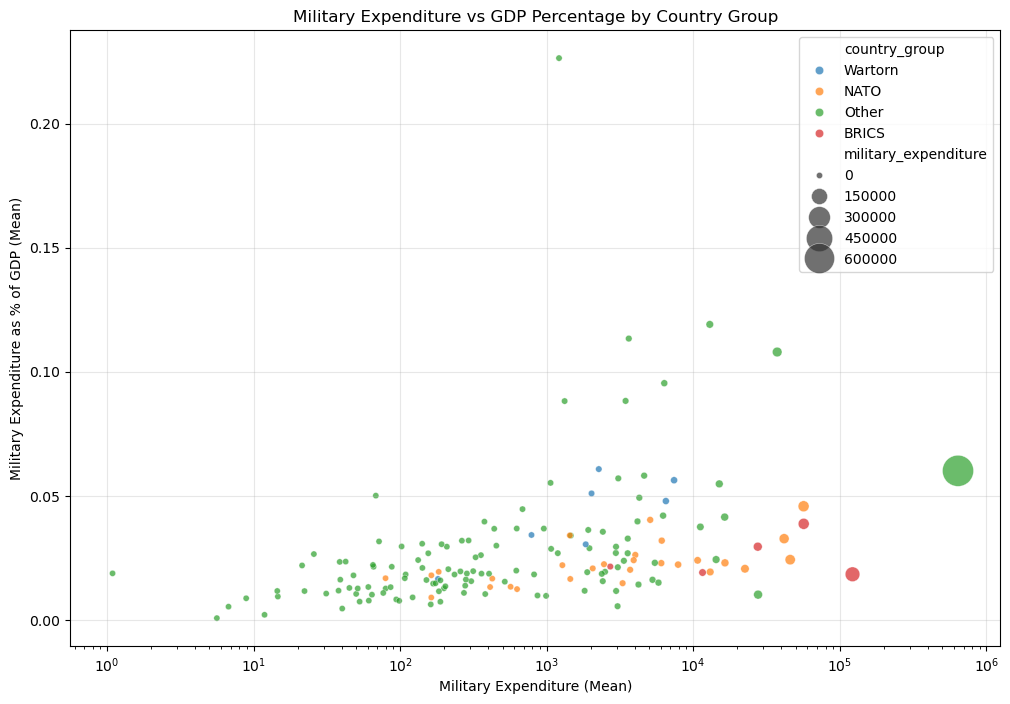

In [4]:
# Define the country groupings
nato_countries = [
    'Belgium', 'Bulgaria', 'Canada', 'Croatia', 'Czechia', 'Denmark', 'Estonia',
    'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Italy', 'Latvia', 
    'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands', 'North Macedonia',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
    'Türkiye', 'United Kingdom', 'Albania'
]

brics_countries = ['Brazil', 'Russia', 'India', 'China', 'South Africa']

wartorn_countries = [
    'Afghanistan', 'Iraq', 'Libya', 'Somalia', 'South Sudan', 'Sudan', 'Syria',
    'Yemen', 'Ukraine'
]

# Create a categorical variable for each country's group
def assign_group(country):
    if country in nato_countries:
        return 'NATO'
    elif country in brics_countries:
        return 'BRICS'
    elif country in wartorn_countries:
        return 'Wartorn'
    else:
        return 'Other'

df['country_group'] = df['country_name'].apply(assign_group)

# Now let's create a pivot table with average military expenditure by country
# First, group by country and calculate means
country_avg = df.groupby('country_name').agg({
    'military_expenditure': 'mean',
    'military_expenditure_gdp': 'mean',
    'country_group': 'first'  # Keep the country group
}).reset_index()

# Display the country groupings
grouped_stats = country_avg.groupby('country_group').agg({
    'country_name': 'count',
    'military_expenditure': 'mean',
    'military_expenditure_gdp': 'mean'
})

print("Country group statistics:")
print(grouped_stats)

# Visualize the relationship between military expenditure and GDP percentage by group
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=country_avg,
    x='military_expenditure',
    y='military_expenditure_gdp',
    hue='country_group',
    size='military_expenditure',
    sizes=(20, 500),
    alpha=0.7
)

plt.title('Military Expenditure vs GDP Percentage by Country Group')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('Military Expenditure (Mean)')
plt.ylabel('Military Expenditure as % of GDP (Mean)')
plt.grid(True, alpha=0.3)

# Calculate correlation between variables by group
group_correlations = {}
for group in df['country_group'].unique():
    group_data = df[df['country_group'] == group]
    corr = group_data[['military_expenditure', 'military_expenditure_gdp']].corr()
    group_correlations[group] = corr
    
print("Correlations by country group:")
for group, corr in group_correlations.items():
    print(f"\n{group}:")
    print(corr)

# Perform PCA on Military Expenditure Data
Prepare the dataset for Principal Component Analysis by handling missing values and standardizing features. Apply PCA to reduce dimensionality. Visualize the results in 2D plots to identify patterns and relationships between different country groups.

Number of components needed for 80% variance: 1


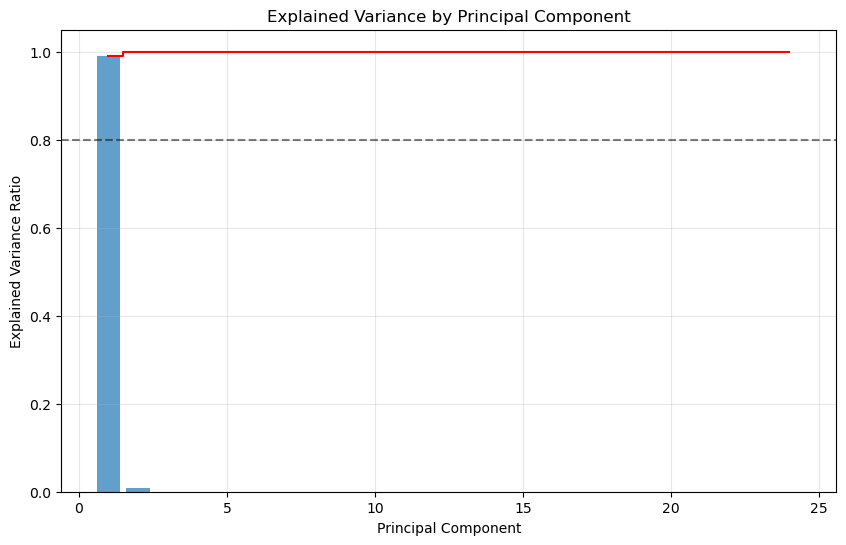

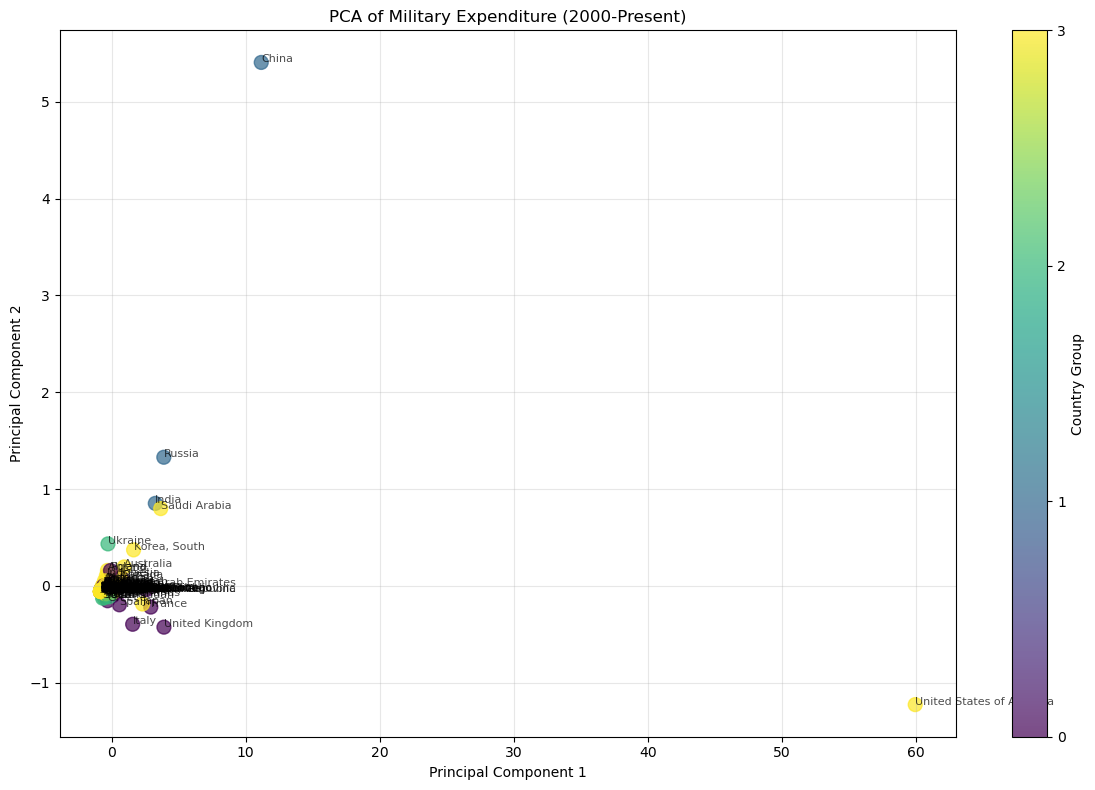

In [5]:
# Cell 4: Perform PCA on military expenditure data
# Prepare data for PCA - we'll use time series data for each country
# Create a pivot table with years as columns and countries as rows
# focusing on military_expenditure

# Filter to only include records from 2000 onwards for better data completeness
recent_df = df[df['year'] >= 2000].copy()

# Create pivot table
pivot_df = recent_df.pivot_table(
    index='country_name',
    columns='year',
    values='military_expenditure',
    aggfunc='mean'
)

# Fill missing values with the mean for that country
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=1)

# Drop countries with too many missing values
pivot_df = pivot_df.dropna(thresh=pivot_df.shape[1] * 0.7)  # Keep countries with at least 70% data

# Add country group info
pivot_df['country_group'] = pivot_df.index.map(lambda x: assign_group(x))

# Separate features and group info
X = pivot_df.drop(columns=['country_group'])
country_groups = pivot_df['country_group']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)

# Find number of components for 80% variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components needed for 80% variance: {n_components}")

# Visualize first two principal components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=[{'NATO': 0, 'BRICS': 1, 'Wartorn': 2, 'Other': 3}[group] for group in country_groups],
    cmap='viridis',
    alpha=0.7,
    s=100
)

# Add country labels
for i, country in enumerate(pivot_df.index):
    plt.annotate(
        country,
        (pca_result[i, 0], pca_result[i, 1]),
        fontsize=8,
        alpha=0.7
    )

plt.title('PCA of Military Expenditure (2000-Present)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Country Group', ticks=[0, 1, 2, 3])
plt.grid(alpha=0.3)
plt.tight_layout()

# Apply K-means Clustering and Compare with Known Groups
Apply K-means clustering algorithm to group countries based on military expenditure patterns. Determine the optimal number of clusters using the elbow method. Compare the resulting clusters with the known country groupings (NATO, BRICS, war-torn) to identify similarities and differences.

K=2, Silhouette Score: 0.9801
K=3, Silhouette Score: 0.8869
K=4, Silhouette Score: 0.8740
K=5, Silhouette Score: 0.7935
K=6, Silhouette Score: 0.7551
K=7, Silhouette Score: 0.6715
K=8, Silhouette Score: 0.6580
K=9, Silhouette Score: 0.6725
Optimal number of clusters: 2
Cluster vs. Country Group:
Actual Group  BRICS  NATO  Other  Wartorn
Cluster                                  
0                 5    29    121        7
1                 0     0      1        0

Summary of Findings:
1. Optimal number of clusters found: 2
2. Cluster composition by country group:

Cluster 0:
  - Countries: Afghanistan, Albania, Algeria, Angola, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahrain, Bangladesh, Belarus, Belgium, Belize, Benin, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Central African Republic, Chad, Chile, China, Colombia, Congo, DR, Congo, Republic, Costa Rica, Cote d'Ivoire, Croatia, Cyprus, C

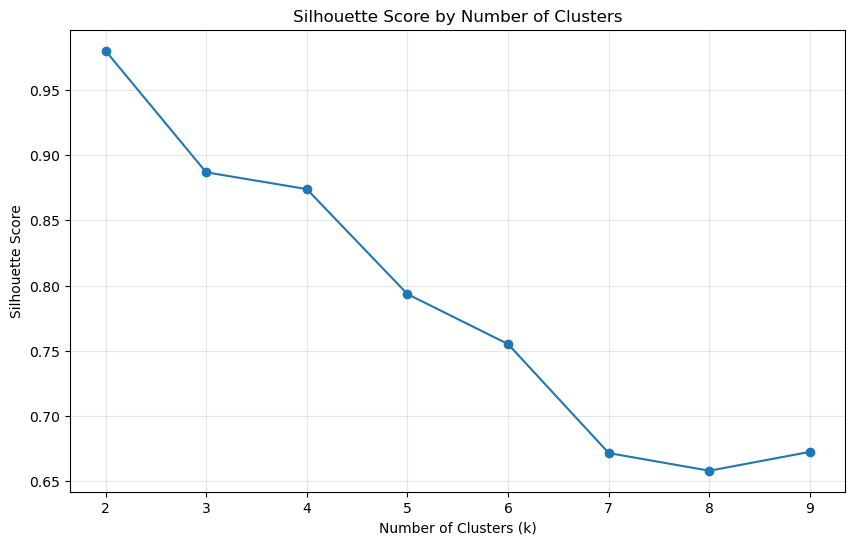

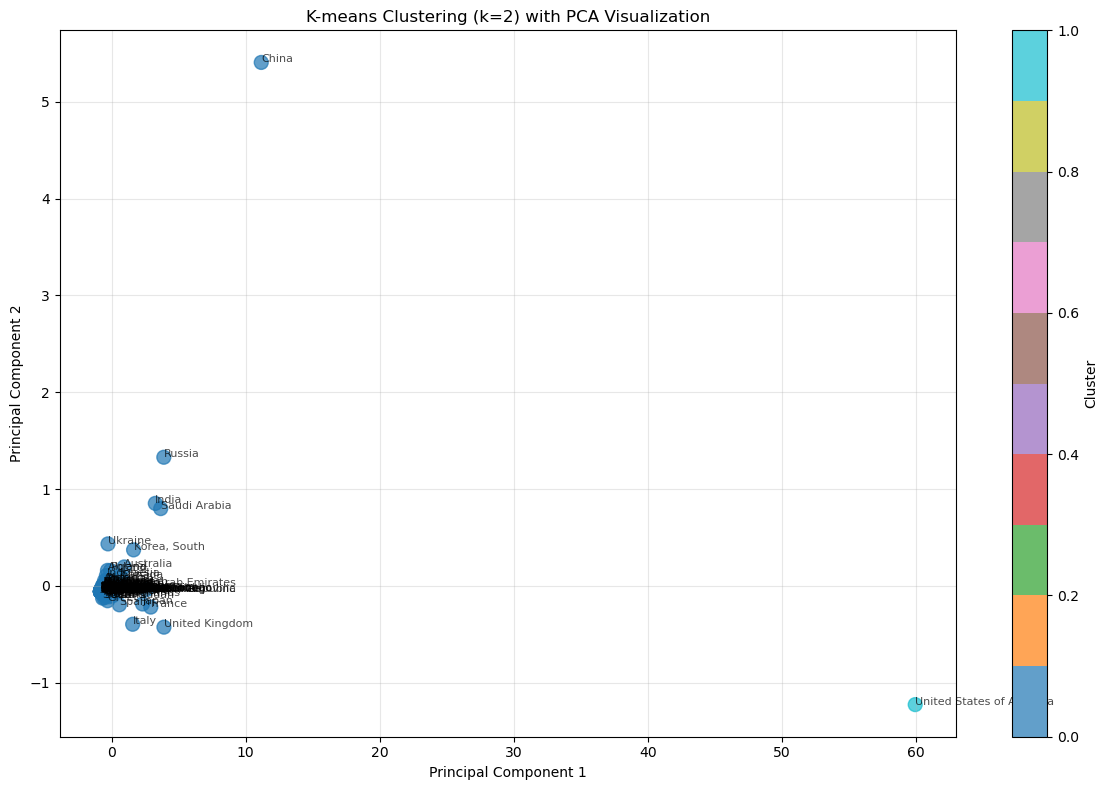

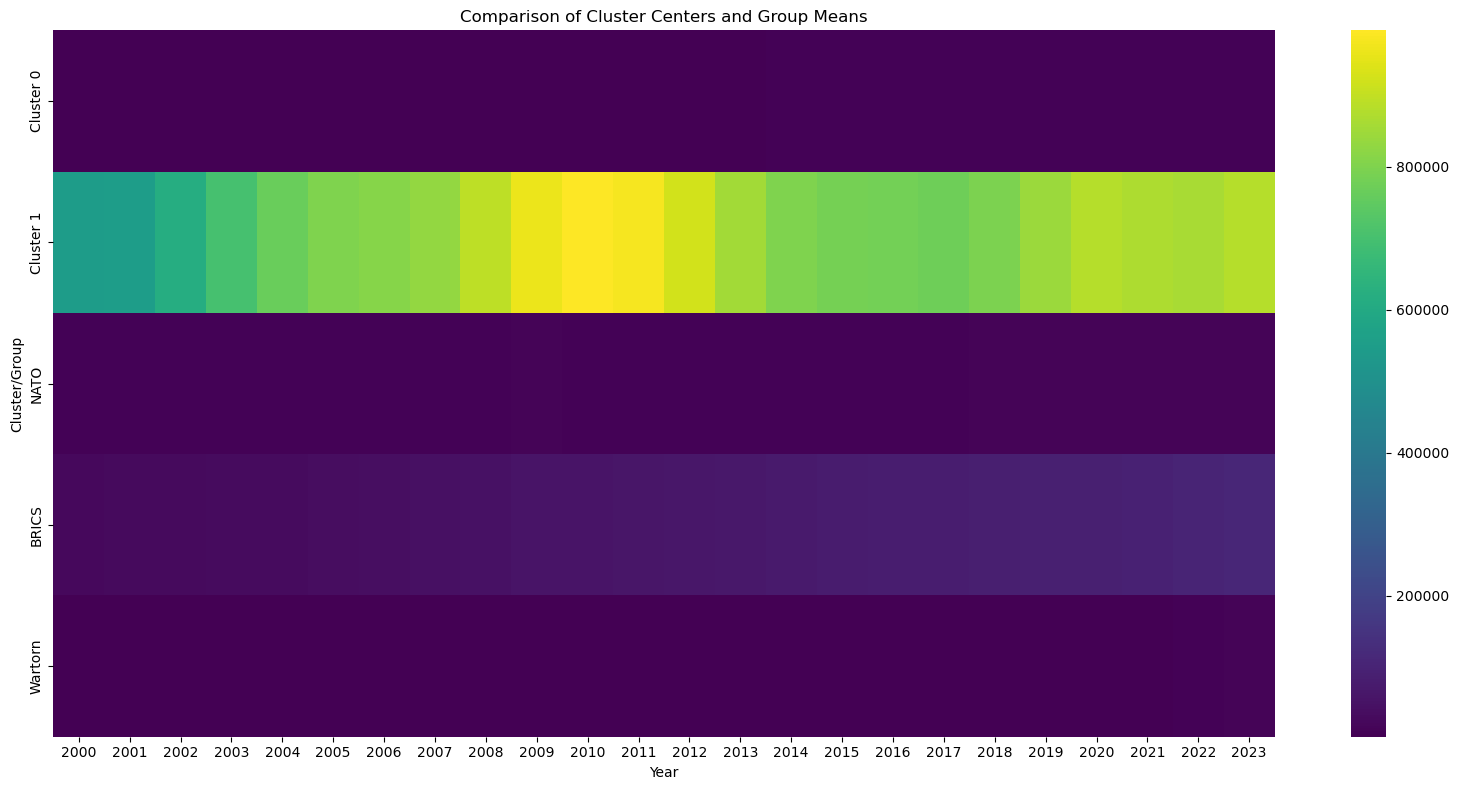

In [6]:
# Cell 5: K-means clustering
# Find optimal number of clusters using silhouette score
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(alpha=0.3)

# Choose k based on silhouette score (usually the highest)
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the data
pivot_df['cluster'] = cluster_labels

# Create a crosstab to see how clustering compares to known country groupings
cluster_vs_group = pd.crosstab(
    pivot_df['cluster'], 
    pivot_df['country_group'],
    rownames=['Cluster'],
    colnames=['Actual Group']
)

print("Cluster vs. Country Group:")
print(cluster_vs_group)

# Visualize the clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=cluster_labels,
    cmap='tab10',
    alpha=0.7,
    s=100
)

# Add country labels
for i, country in enumerate(pivot_df.index):
    plt.annotate(
        country,
        (pca_result[i, 0], pca_result[i, 1]),
        fontsize=8,
        alpha=0.7
    )

plt.title(f'K-means Clustering (k={optimal_k}) with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()

# Cell 6: Compare cluster centers with known groups
# Get cluster centers in original feature space
cluster_centers = kmeans.cluster_centers_
# Transform back to original scale
cluster_centers_original = scaler.inverse_transform(cluster_centers)

# Create a DataFrame with cluster centers
cluster_centers_df = pd.DataFrame(
    cluster_centers_original,
    columns=X.columns,
    index=[f"Cluster {i}" for i in range(optimal_k)]
)

# Calculate mean values for each known group
group_means = {}
for group in ['NATO', 'BRICS', 'Wartorn']:
    group_countries = pivot_df[pivot_df['country_group'] == group].index
    group_means[group] = X.loc[group_countries].mean()

# Add group means to cluster_centers_df
for group, means in group_means.items():
    cluster_centers_df.loc[group] = means

# Plot a heatmap of cluster centers vs group means
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_centers_df, cmap='viridis', annot=False)
plt.title('Comparison of Cluster Centers and Group Means')
plt.ylabel('Cluster/Group')
plt.xlabel('Year')
plt.tight_layout()

# Summary of findings
print("\nSummary of Findings:")
print(f"1. Optimal number of clusters found: {optimal_k}")
print("2. Cluster composition by country group:")
for cluster in range(optimal_k):
    countries = pivot_df[pivot_df['cluster'] == cluster].index.tolist()
    groups = pivot_df[pivot_df['cluster'] == cluster]['country_group'].value_counts()
    print(f"\nCluster {cluster}:")
    print(f"  - Countries: {', '.join(countries)}")
    print(f"  - Group composition: {dict(groups)}")